<h2>Esimerkki sqlite-tietokannan käytöstä</h2>

<p>Tietokannan voit ladata itsellesi osoitteesta 
<a href="http://taanila.fi/Northwind_large.sqlite">http://taanila.fi/Northwind_large.sqlite</a></p>
    

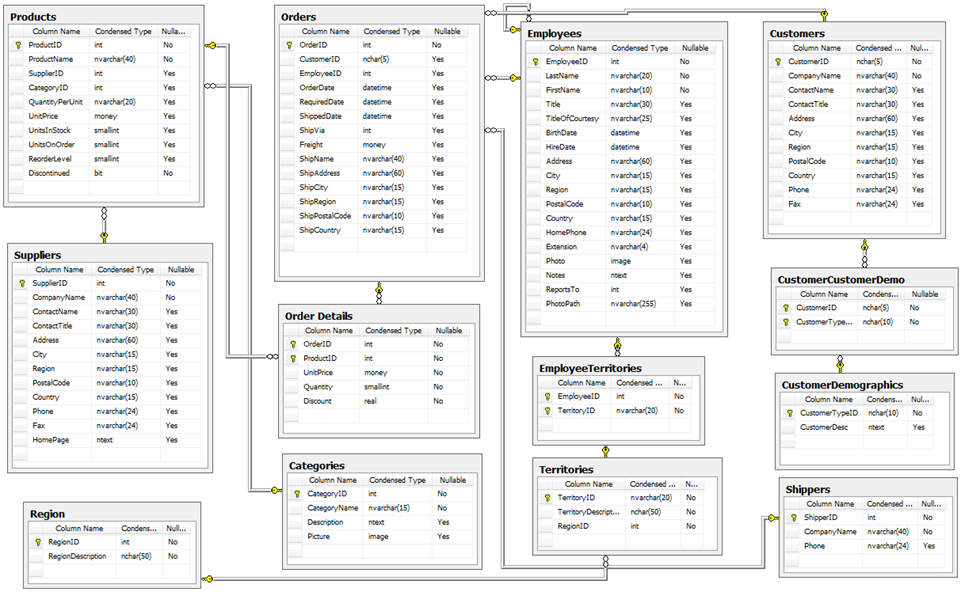

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

conn = sqlite3.connect('Northwind_large.sqlite')
cur = conn.cursor()

In [2]:
# Tietokannan taulut

cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
print(cur.fetchall())

[('Employees',), ('Categories',), ('Customers',), ('Shippers',), ('Suppliers',), ('Orders',), ('Products',), ('OrderDetails',), ('CustomerCustomerDemo',), ('CustomerDemographics',), ('Region',), ('Territories',), ('EmployeeTerritories',)]


In [3]:
# Taulun kentät

cur.execute("PRAGMA table_info(OrderDetails)")
print(cur.fetchall())

[(0, 'Id', 'VARCHAR(8000)', 0, None, 1), (1, 'OrderId', 'INTEGER', 1, None, 0), (2, 'ProductId', 'INTEGER', 1, None, 0), (3, 'UnitPrice', 'DECIMAL', 1, None, 0), (4, 'Quantity', 'INTEGER', 1, None, 0), (5, 'Discount', 'DOUBLE', 1, None, 0)]


In [4]:
# SQL-kyselyn tulos dataframeen

df = pd.read_sql_query("""SELECT Orders.OrderDate, Products.ProductName, Categories.CategoryName, 
    OrderDetails.UnitPrice, OrderDetails.Quantity, OrderDetails.Discount, Customers.CompanyName,
    Orders.ShipCountry, Orders.ShipRegion, Orders.ShipVia, Employees.LastName  
    FROM OrderDetails 
    JOIN Orders ON Orders.Id=OrderDetails.OrderId
    JOIN Employees ON Employees.Id=Orders.EmployeeId
    JOIN Customers ON Customers.Id=Orders.CustomerId
    JOIN Products ON Products.Id=OrderDetails.ProductId
    JOIN Categories ON Products.CategoryId=Categories.Id""", conn)

df.shape

(621806, 11)

In [5]:
# Päivämäärät indeksiin

df.index = pd.to_datetime(df['OrderDate'])
df = df.drop('OrderDate', axis=1)
df.sort_index(inplace=True)

# Sarakkeen uudelleen nimeäminen
df.rename(columns={'LastName':'SalesPerson'}, inplace=True)

df.tail()

,ProductName,CategoryName,UnitPrice,Quantity,Discount,CompanyName,ShipCountry,ShipRegion,ShipVia,SalesPerson
OrderDate,,,,,,,,,,
2016-02-19 22:36:39,Laughing Lumberjack Lager,Beverages,14.0,45,0.0,Folies gourmandes,Mexico,Central America,2,Callahan
2016-02-19 22:36:39,Spegesild,Seafood,12.0,35,0.0,Folies gourmandes,Mexico,Central America,2,Callahan
2016-02-19 22:36:39,Gnocchi di nonna Alice,Grains/Cereals,38.0,3,0.0,Folies gourmandes,Mexico,Central America,2,Callahan
2016-02-19 22:36:39,Original Frankfurter grüne Soße,Condiments,13.0,33,0.0,Folies gourmandes,Mexico,Central America,2,Callahan
2016-02-19 22:36:39,Outback Lager,Beverages,15.0,23,0.0,Folies gourmandes,Mexico,Central America,2,Callahan


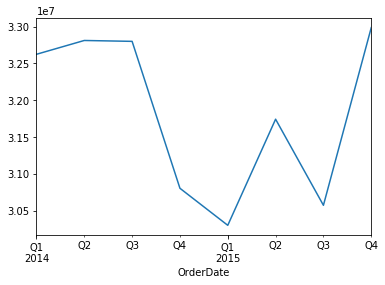

In [6]:
# Tilausrivin kokonaissumma
df['Total'] = df['UnitPrice']*df['Quantity']*(1-df['Discount'])

# Tilaukset vuosineljänneksittäin 2014-2015
df['2014':'2015']['Total'].resample('Q').sum().plot()

In [7]:
# Myynnit alueittain
df.pivot_table(values='Total', index='ShipRegion', aggfunc=sum).sort_values(by='Total', 
            ascending=False).style.format('{:.0f}')

,Total
ShipRegion,
Western Europe,143783825
South America,81826582
North America,80042603
Southern Europe,43369206
British Isles,42054821
Central America,25728089
Northern Europe,20681051
Scandinavia,15468057
Eastern Europe,4874972


In [8]:
# Myyjien myynnit alueittain vuonna 2015
df['2015'].pivot_table(values='Total',columns='ShipRegion', 
            index='SalesPerson', aggfunc=sum).style.format('{:.0f}')

ShipRegion,British Isles,Central America,Eastern Europe,North America,Northern Europe,Scandinavia,South America,Southern Europe,Western Europe
SalesPerson,,,,,,,,,
Buchanan,1140139,777821,87747,2580443,911757,375717,2783018,781339,4217372
Callahan,1452592,647614,65154,2561733,441240,310492,2559595,1072740,3997767
Davolio,1363071,812916,292521,2056418,683548,587754,2606509,1143172,4362188
Dodsworth,1161943,889162,151539,1991106,573354,471887,2741282,928782,4875433
Fuller,1091760,986251,138551,2650126,460450,364876,3240379,1199142,4080271
King,1507273,911735,141710,2184592,798335,804845,2291608,1393939,4893079
Leverling,1267842,643008,41788,2162851,590249,631910,2984044,1690656,3972434
Peacock,1030521,694773,104165,2666401,655336,463104,2678378,1075086,4518509
Suyama,1333980,1066896,186342,2689972,731933,248140,2531446,1448415,3901694


In [9]:
# Edellinen toisella tavalla
df['2015'].pivot_table(values='Total', index=['SalesPerson','ShipRegion'], 
                    aggfunc='sum').style.format('{:.0f}')

In [10]:
# Rahtaajien käyttö myyjittäin
(pd.crosstab(df['SalesPerson'], df['ShipVia'], normalize='index')*100).style.format('{:.1f} %')

ShipVia,1,2,3
SalesPerson,,,
Buchanan,34.2 %,32.6 %,33.2 %
Callahan,29.9 %,36.0 %,34.1 %
Davolio,32.6 %,33.6 %,33.8 %
Dodsworth,34.6 %,32.8 %,32.6 %
Fuller,34.0 %,33.8 %,32.2 %
King,32.1 %,32.7 %,35.2 %
Leverling,34.2 %,30.7 %,35.1 %
Peacock,32.7 %,32.8 %,34.5 %
Suyama,34.8 %,32.6 %,32.6 %


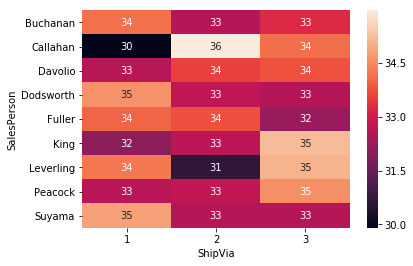

In [11]:
# Edellinen havainnollisemmin
import seaborn as sns
sns.heatmap(data=(pd.crosstab(df['SalesPerson'], df['ShipVia'], normalize='index')*100), annot=True)

In [12]:
conn.close()